In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cnfg
import re
import os
from sqlalchemy import create_engine
from gensim import corpora, models, similarities, matutils
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from gensim.models import word2vec
from gensim import models
from collections import defaultdict
from sklearn.manifold import TSNE
import nltk

import logging
from sklearn.decomposition import TruncatedSVD, NMF

# logging for gensim (set to INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
                        config['db_user'],
                        config['db_pwd'],
                        config['db_host'],
                        'sephora'))

query_product = """SELECT * FROM sephora_product WHERE category IN ('moisturizers', 'face serums', 'face wash & cleansers',
         'eye creams & treatments', 'face masks', 'moisturizer & treatments',
         'face oils')"""
df_product = pd.read_sql_query(query_product, engine)
# df_product = pd.read_csv('data/sephora_product.csv')
df_product = df_product.set_index('id')
df_product.head(3)

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price
id,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80


In [3]:
query_review = 'SELECT * FROM sephora_product_review'
df = pd.read_sql_query(query_review, engine)
# df = pd.read_csv('data/sephora_review.csv')
# df = df[df.rating <= 3]
df.head()

,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_id
0,P411015,,I don't wear makeup but I love the highlighted...,5,None,None,None,None,Lexium,None,8f7a235d-71ec-4d55-a7fb-5275964dc47f
1,P411015,Much too shiny/shimmery,This glotion is much to shimmery and when used...,2,None,dry,None,None,dsmartin,None,f9e384e1-2182-49e8-9e8b-c3df0f22d263
2,P411015,,Love this product! It's a wonderful way to giv...,5,None,None,None,None,MsZabeth,None,4a9ea1fa-3638-4bee-83db-85150f6db2e2
3,P411015,Very Dissapointed,"If I could give this no stars, I would.",1,None,normal,None,None,dbaeznyc923,None,41814923-6e1f-4083-95a1-1bc0643c803d
4,P411015,,It leaves a white cast like a sunscreen would....,3,None,None,None,None,selinakyle88,None,13236fb4-242b-44a8-8fc0-e6896d3aed24


In [4]:
# df = df.set_index('review_id')

# Split review_text into sentences
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs'])
tokenizer = PunktSentenceTokenizer(punkt_param)
tokenizer.tokenize('Dr. Smith is a doctor. He is the best ... not')

['Dr. Smith is a doctor.', 'He is the best ... not']

In [5]:
df['review_sentences'] = df['review_text'].map(lambda text: tokenizer.tokenize(text))

In [6]:
sample_review_index = 3
print(df.iloc[sample_review_index]['review_text'])
df.iloc[sample_review_index]['review_sentences']

If I could give this no stars, I would. 


['If I could give this no stars, I would.']

In [7]:
def split_long_sentence(sentences):
    shorter_sentences = []
    for sentence in sentences:
        if len(sentence) >= 50:
            sub_sentences = re.split('&|!|;|and|,|~|but|\.|so i|\s-\s|\(|\)', sentence.lower())
            sub_sentences = [s.strip() for s in sub_sentences]
            shorter_sentences += sub_sentences
        else:
            shorter_sentences.append(sentence.lower())
    shorter_sentences = filter(lambda s: len(s) > 13 
                               and not s.startswith('i have')
                               and not s.startswith('i also have')
                               and not s.startswith('i\'m')
                               and not s.startswith('i had')
                               and not s.startswith('i\'ve been')
                               and not s.startswith('i thought')
                               and not s.startswith('i was ')
                               and not s.startswith('i use ')
                               and not s.startswith('i used to')
                               and not s.startswith('if you have')
                               and not ('i do have' in s)
                               and not ('looking for' in s)
                               and not ('i purchase' in s)
                               and not ('i bought' in s)
                               , shorter_sentences)
    return list(shorter_sentences)

split_long_sentence([
    "I have mild acne",
    "i do have to comment on the packaging because it is as terrible as everyone says it is"
    "Totally I was on the lookout for a long time fora great moisturizer",
    "At first it took a few times to figure out the best way to wrap the magnet (if you don't it's almost impossible to get the product off) then this is great",
    "It absorbs fairly quick - 3-5 minutes depending on how much serum you use.",
    "It's too oily to use as an eye-makeup remover and the scent is over powering, the dispenser does not work well", 
    "It'll leave this oily film over your eye balls and cloud your vision until your eye does its job but coughs the film back out in the form of an eye booger...so maybe not",
    "almost can feel like it is burning sometimes so I have to use this on nights I am not doing anything other than washing my face."])

['at first it took a few times to figure out the best way to wrap the magnet',
 "if you don't it's almost impossible to get the product off",
 'then this is great',
 'it absorbs fairly quick',
 '3-5 minutes depending on how much serum you use',
 "it's too oily to use as an eye-makeup remover",
 'the scent is over powering',
 'the dispenser does not work well',
 "it'll leave this oily film over your eye balls",
 'cloud your vision until your eye does its job',
 'coughs the film back out in the form of an eye booger',
 'almost can feel like it is burning sometimes',
 'have to use this on nights i am not doing anything other than washing my face']

In [8]:
# Build a new dataframe with each sentence as a document
review_ids = []
review_sentences = []
for review in df.as_matrix():
    curr_review_id = review[-2]
    curr_review_sentences = review[-1]
    
    # Divide long sentences even longer if possible!
    shorter_sentences = split_long_sentence(curr_review_sentences)
    
    review_ids += [curr_review_id] * len(shorter_sentences)
    review_sentences += shorter_sentences
    
df_review_sentences = pd.DataFrame({'review_id': review_ids, 'sentence': review_sentences})
df_review_sentences.head()

,review_id,sentence
0,8f7a235d-71ec-4d55-a7fb-5275964dc47f,i don't wear makeup
1,8f7a235d-71ec-4d55-a7fb-5275964dc47f,i love the highlighted look
2,8f7a235d-71ec-4d55-a7fb-5275964dc47f,this is perfect
3,8f7a235d-71ec-4d55-a7fb-5275964dc47f,it doesn't feel cakey or break me out
4,8f7a235d-71ec-4d55-a7fb-5275964dc47f,i don't think it's too glittery or bright.


In [9]:
df_review_sentences.shape

(744640, 2)

## Tokenizer

In [10]:
# Get stop words
stop_words = set(open('data/stopwords_v2.txt').read().split())

In [11]:
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    tokens = [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]
    filtered_tokens = filter(lambda tok: tok not in stop_words, tokens)
    return list(filtered_tokens)

In [12]:
tokenize('skin abc & def<')

['abc', 'def']

## TF-IDF

In [13]:
def get_word_weights(docs):
    tfidf = TfidfVectorizer(stop_words=frozenset(), 
                            tokenizer=tokenize,
                            ngram_range=(1,1))
    tfidf.fit(docs)
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(lambda: max_idf,
                                    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return word2weight
    
test_docs2 = ["dog cat fish","dog cat cat","fish bird", 'bird fish. bird', 'blah cat', 'tata harper']
get_word_weights(test_docs2)

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'bird': 1.8472978603872037,
             'blah': 2.2527629684953681,
             'cat': 1.5596157879354227,
             'dog': 1.8472978603872037,
             'fish': 1.5596157879354227})

## Word2Vec

In [14]:
w2v = models.KeyedVectors.load_word2vec_format("../GoogleNews-vectors-negative300.bin",binary=True)

2017-08-24 10:31:33,732 : INFO : loading projection weights from ../GoogleNews-vectors-negative300.bin
2017-08-24 10:32:42,028 : INFO : loaded (3000000, 300) matrix from ../GoogleNews-vectors-negative300.bin


In [15]:
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
# w2v['wrinkle']

In [16]:
w2v.most_similar(positive=['wrinkle'], topn=25)

2017-08-24 10:32:42,038 : INFO : precomputing L2-norms of word weight vectors


[('wrinkles', 0.6509594917297363),
 ('twist', 0.5201830863952637),
 ('cellulite', 0.4519196152687073),
 ('wrinkle_remover', 0.4473875164985657),
 ('kink', 0.43007057905197144),
 ('creases', 0.4271658658981323),
 ('Botox', 0.42587846517562866),
 ('wrinkle_reducer', 0.42533019185066223),
 ("crow's_feet", 0.42372927069664),
 ('wrinkle_filler', 0.42249032855033875),
 ('Prevage', 0.4219375550746918),
 ('dimension', 0.41997307538986206),
 ('volumizing', 0.41956183314323425),
 ('Frownies', 0.4190055727958679),
 ('slenderizing', 0.41443490982055664),
 ('eye_makeup_remover', 0.41385316848754883),
 ('stimulates_collagen_production', 0.41349709033966064),
 ('aging_creams', 0.41251763701438904),
 ('cellulite_creams', 0.41042596101760864),
 ('exfoliant', 0.40742120146751404),
 ('facial_creases', 0.4038386642932892),
 ('aging_serums', 0.40091755986213684),
 ('Sculptra', 0.40089690685272217),
 ('translucent_powder', 0.40067803859710693),
 ('self_tanner', 0.4004167914390564)]

In [17]:
'review' in w2v.vocab

True

In [18]:
df_review_sentences['tokenized_words'] = df_review_sentences['sentence'].map(lambda sentence: tokenize(sentence))
df_review_sentences['tokenized_filtered_words'] = df_review_sentences['tokenized_words'].map(
    lambda tokenized_words: [word for word in tokenized_words if word in w2v.vocab])
df_review_sentences['tokenized_filtered_words_length'] = df_review_sentences['tokenized_filtered_words'].map(
    lambda tokenized_filtered_words: len(tokenized_filtered_words))

In [19]:
# Remove sentences that less than 4 words
df_review_sentences = df_review_sentences[df_review_sentences.tokenized_filtered_words_length > 3]
df_review_sentences = df_review_sentences.reset_index()
word2weight = get_word_weights(df_review_sentences['sentence'])

In [20]:
# Use parts of speech
def get_pos_weight(tokens):
    word_pos = nltk.pos_tag(tokens)
    word_to_weight = {}
    for word, pos in word_pos:
        if pos.startswith('JJ'):
            # adjective
            word_to_weight[word] = 4
        elif pos.startswith('RB'):
            # adverb
            word_to_weight[word] = 3
        elif pos.startswith('VB'):
            # verb
            word_to_weight[word] = 2
        else: 
            word_to_weight[word] = 1
    return word_to_weight
    
    
# nltk.pos_tag(['month', 'three', 'major', 'quickly', 'definitely'])
#'vba'.startswith('vb')


def word2vec_pos_weight(tokenized_filtered_words):
    pos_weights = get_pos_weight(tokenized_filtered_words)
    return np.mean([w2v[w] * pos_weights[w]
             for w in tokenized_filtered_words], axis=0)

# word2vec_pos_weight(['month', 'three', 'major', 'quickly', 'definitely'])

In [21]:
# For each sentence, find word2vec vector
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
def word2vec_tfidf(tokenized_filtered_words):
    return np.mean([w2v[w] * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

word2vec_tfidf(['apple', 'banana']).shape

(300,)

In [22]:
df_review_sentences['word2vec'] = df_review_sentences['tokenized_filtered_words'].map(
    # lambda tokenized_filtered_words: np.mean(w2v[tokenized_filtered_words], axis=0)
    # lambda tokenized_filtered_words: word2vec_tfidf(tokenized_filtered_words)
    lambda tokenized_filtered_words: word2vec_pos_weight(tokenized_filtered_words)
)
df_review_sentences.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec
0,3,8f7a235d-71ec-4d55-a7fb-5275964dc47f,it doesn't feel cakey or break me out,"[doesn't, feel, cakey, or, break, me]","[doesn't, feel, cakey, or, break, me]",6,"[0.0308431, 0.00958252, -0.0441488, 0.144043, ..."
1,4,8f7a235d-71ec-4d55-a7fb-5275964dc47f,i don't think it's too glittery or bright.,"[don't, think, it's, glittery, or, bright]","[don't, think, it's, glittery, or, bright]",6,"[0.147441, -0.0728353, 0.115743, 0.39681, -0.2..."
2,6,8f7a235d-71ec-4d55-a7fb-5275964dc47f,the best part is that it shows up on my light ...,"[best, part, that, shows, light]","[best, part, that, shows, light]",5,"[-0.0922546, 0.0911621, 0.204285, 0.146484, 0...."
3,8,f9e384e1-2182-49e8-9e8b-c3df0f22d263,when used all over the face,"[when, used, all, over]","[when, used, all, over]",4,"[0.164062, 0.079895, 0.169098, 0.104126, -0.10..."
4,10,f9e384e1-2182-49e8-9e8b-c3df0f22d263,does not look at all natural,"[does, not, look, at, all, natural]","[does, not, look, at, all, natural]",6,"[0.0712077, 0.149882, 0.0592448, 0.266846, -0...."


In [23]:
# pd.DataFrame(df_review_sentences['word2vec'].values.tolist())

In [24]:
sentence_word_vectors = np.array(df_review_sentences['word2vec'].values.tolist())

## Clustering Functions

In [25]:
def plot_kmeans_inertia(data):
    """Figure out optimized number of clusters for KMeans"""
    max_number_clusters = 20
    inertia_values = []
    for cluster_count in range(1, max_number_clusters+1):
        print('fitting cluster ', cluster_count)
        km = KMeans(n_clusters=cluster_count)
        km.fit(data)
        inertia_values.append(km.inertia_)

    plt.plot(range(1, max_number_clusters+1), inertia_values)

## Aglomerative Clustering

## K-Means

In [26]:
sentence_word_vectors.shape

(401946, 300)

In [27]:
cluster_count = 30
number_sentences = sentence_word_vectors.shape[0]
df_review_sentences_truncated = df_review_sentences.iloc[0:number_sentences, :]
sentence_word_vectors_truncated = sentence_word_vectors[0:number_sentences, :]
sentence_word_vectors_truncated = normalize(sentence_word_vectors_truncated)
sentence_word_vectors_truncated.shape

(401946, 300)

In [28]:
km = MiniBatchKMeans(n_clusters=cluster_count)
review_word2vec_clusters = km.fit_predict(sentence_word_vectors_truncated)
len(review_word2vec_clusters)

401946

In [29]:
# Create vector of sentence to cluster number
df_sentence_cluster = pd.DataFrame({})
cluster_columns = ['feat_' + str(i) for i in range(0, cluster_count)]
for i in range(0, cluster_count):
    cluster_column = cluster_columns[i]
    df_sentence_cluster[cluster_column] = (review_word2vec_clusters == i).astype(int)
    
df_sentence = pd.concat([df_review_sentences, df_sentence_cluster], axis=1)
df_sentence[df_sentence['feat_0'] == 1].head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,feat_0,feat_1,feat_2,...,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29
18,34,35be24c1-28f7-415a-8bc7-734c21c0ab94,when i used it for the first time i was so exc...,"[when, used, was, excited]","[when, used, was, excited]",4,"[0.0571899, 0.256348, 0.382812, -0.0513306, 0....",1,0,0,...,0,0,0,0,0,0,0,0,0,0
161,278,c3bcfbce-c45f-496e-9530-1a8e6123bef4,the cleanser does a better job at removing mas...,"[does, better, job, at, removing, than]","[does, better, job, at, removing, than]",6,"[-0.130117, 0.0537109, -0.00696564, 0.164286, ...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
164,283,8255954b-ebf4-4853-b3ab-4591d2629af2,i wanted something that would foam up better w...,"[wanted, something, that, would, foam, better,...","[wanted, something, that, would, foam, better,...",7,"[-0.111067, 0.0373535, 0.112549, 0.124442, -0....",1,0,0,...,0,0,0,0,0,0,0,0,0,0
216,399,4955ed99-9be5-457c-8414-ce48a3838b08,my crows feet have gotten better,"[crows, feet, have, gotten, better]","[crows, feet, have, gotten, better]",5,"[-0.202441, 0.0154297, -0.205835, 0.201498, -0...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
220,404,4955ed99-9be5-457c-8414-ce48a3838b08,i wish it were a bit cheaper because the tube ...,"[wish, were, bit, cheaper, because, tube, small]","[wish, were, bit, cheaper, because, tube, small]",7,"[-0.057251, 0.0616281, -0.0561349, 0.418178, -...",1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merging Review Sentences with Products

In [30]:
df_sentence_product = pd.merge(df_sentence, df, on='review_id', how='left')
df_sentence_product.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,feat_0,feat_1,feat_2,...,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_sentences
0,3,8f7a235d-71ec-4d55-a7fb-5275964dc47f,it doesn't feel cakey or break me out,"[doesn't, feel, cakey, or, break, me]","[doesn't, feel, cakey, or, break, me]",6,"[0.0308431, 0.00958252, -0.0441488, 0.144043, ...",0,0,0,...,,I don't wear makeup but I love the highlighted...,5,None,None,None,None,Lexium,None,[I don't wear makeup but I love the highlighte...
1,4,8f7a235d-71ec-4d55-a7fb-5275964dc47f,i don't think it's too glittery or bright.,"[don't, think, it's, glittery, or, bright]","[don't, think, it's, glittery, or, bright]",6,"[0.147441, -0.0728353, 0.115743, 0.39681, -0.2...",0,1,0,...,,I don't wear makeup but I love the highlighted...,5,None,None,None,None,Lexium,None,[I don't wear makeup but I love the highlighte...
2,6,8f7a235d-71ec-4d55-a7fb-5275964dc47f,the best part is that it shows up on my light ...,"[best, part, that, shows, light]","[best, part, that, shows, light]",5,"[-0.0922546, 0.0911621, 0.204285, 0.146484, 0....",0,0,0,...,,I don't wear makeup but I love the highlighted...,5,None,None,None,None,Lexium,None,[I don't wear makeup but I love the highlighte...
3,8,f9e384e1-2182-49e8-9e8b-c3df0f22d263,when used all over the face,"[when, used, all, over]","[when, used, all, over]",4,"[0.164062, 0.079895, 0.169098, 0.104126, -0.10...",0,0,0,...,Much too shiny/shimmery,This glotion is much to shimmery and when used...,2,None,dry,None,None,dsmartin,None,[This glotion is much to shimmery and when use...
4,10,f9e384e1-2182-49e8-9e8b-c3df0f22d263,does not look at all natural,"[does, not, look, at, all, natural]","[does, not, look, at, all, natural]",6,"[0.0712077, 0.149882, 0.0592448, 0.266846, -0....",0,0,0,...,Much too shiny/shimmery,This glotion is much to shimmery and when used...,2,None,dry,None,None,dsmartin,None,[This glotion is much to shimmery and when use...


In [31]:
# Split dataframe into two dataframes, one with positive sentences, another with negative sentences
# Positive sentences:
df_sentence_product_pos = df_sentence_product[df_sentence_product.rating > 3]
df_sentence_product_neg = df_sentence_product[df_sentence_product.rating <= 3]

# Rename features in df_sentence_product_neg
neg_feature_columns = ['neg_' + col_name for col_name in cluster_columns]
# df.rename(columns={'Leader': 'Commander'}, inplace=True)
df_sentence_product_neg.rename(columns=dict(zip(cluster_columns, neg_feature_columns)), inplace=True)
df_sentence_product_neg.head()


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,neg_feat_0,neg_feat_1,neg_feat_2,...,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_sentences
3,8,f9e384e1-2182-49e8-9e8b-c3df0f22d263,when used all over the face,"[when, used, all, over]","[when, used, all, over]",4,"[0.164062, 0.079895, 0.169098, 0.104126, -0.10...",0,0,0,...,Much too shiny/shimmery,This glotion is much to shimmery and when used...,2,None,dry,None,None,dsmartin,None,[This glotion is much to shimmery and when use...
4,10,f9e384e1-2182-49e8-9e8b-c3df0f22d263,does not look at all natural,"[does, not, look, at, all, natural]","[does, not, look, at, all, natural]",6,"[0.0712077, 0.149882, 0.0592448, 0.266846, -0....",0,0,0,...,Much too shiny/shimmery,This glotion is much to shimmery and when used...,2,None,dry,None,None,dsmartin,None,[This glotion is much to shimmery and when use...
5,11,f9e384e1-2182-49e8-9e8b-c3df0f22d263,it does ok in very small amounts as a spot hig...,"[does, ok, very, small, amounts, as, spot, hig...","[does, ok, very, small, amounts, as, spot, hig...",8,"[0.175991, 0.109528, -0.0448456, 0.208946, -0....",0,0,0,...,Much too shiny/shimmery,This glotion is much to shimmery and when used...,2,None,dry,None,None,dsmartin,None,[This glotion is much to shimmery and when use...
12,23,41814923-6e1f-4083-95a1-1bc0643c803d,"if i could give this no stars, i would.","[if, could, give, stars, would]","[if, could, give, stars, would]",5,"[0.0856689, 0.000537109, 0.124902, 0.150684, -...",0,0,0,...,Very Dissapointed,"If I could give this no stars, I would.",1,None,normal,None,None,dbaeznyc923,None,"[If I could give this no stars, I would.]"
13,24,13236fb4-242b-44a8-8fc0-e6896d3aed24,it leaves a white cast like a sunscreen would.,"[leaves, white, cast, like, would]","[leaves, white, cast, like, would]",5,"[0.14707, 0.16582, 0.0545807, -0.0119385, 0.05...",0,0,0,...,,It leaves a white cast like a sunscreen would....,3,None,None,None,None,selinakyle88,None,[It leaves a white cast like a sunscreen would...


In [32]:
# Stack positive and negative dataframes on top of each other
df_sentence_product_pos_neg = pd.concat([df_sentence_product_pos, df_sentence_product_neg])
df_sentence_product_pos_neg = df_sentence_product_pos_neg.fillna(0)
df_sentence_product_pos_neg = df_sentence_product_pos_neg.reset_index()

In [33]:
# df_sentence_product_pos_neg.iloc[-4][neg_feature_columns + ['sentence']]
df_sentence_product_pos_neg.head()

,level_0,age_range,eye_color,feat_0,feat_1,feat_10,feat_11,feat_12,feat_13,feat_14,...,review_title,reviewer_username,sentence,skin_tone,skin_type,tags,tokenized_filtered_words,tokenized_filtered_words_length,tokenized_words,word2vec
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,,Lexium,it doesn't feel cakey or break me out,0,0,0,"[doesn't, feel, cakey, or, break, me]",6,"[doesn't, feel, cakey, or, break, me]","[0.0308431, 0.00958252, -0.0441488, 0.144043, ..."
1,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,,Lexium,i don't think it's too glittery or bright.,0,0,0,"[don't, think, it's, glittery, or, bright]",6,"[don't, think, it's, glittery, or, bright]","[0.147441, -0.0728353, 0.115743, 0.39681, -0.2..."
2,2,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,,Lexium,the best part is that it shows up on my light ...,0,0,0,"[best, part, that, shows, light]",5,"[best, part, that, shows, light]","[-0.0922546, 0.0911621, 0.204285, 0.146484, 0...."
3,6,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,,MsZabeth,it's a wonderful way to give your face,0,0,0,"[it's, wonderful, give, your]",4,"[it's, wonderful, give, your]","[0.218658, -0.125977, 0.060791, 0.606445, -0.2..."
4,7,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,,MsZabeth,all-over glow without adding color like a tint...,0,0,0,"[all, over, glow, without, adding, color, like...",9,"[all, over, glow, without, adding, color, like...","[0.0470208, 0.14072, 0.0886587, 0.0590617, -0...."


In [34]:
# Write to CSV
all_feature_columns = cluster_columns + neg_feature_columns
for feature_name in all_feature_columns:
    df_sentences_with_feature = df_sentence_product_pos_neg[df_sentence_product_pos_neg[feature_name] != 0]
    print('Cluster {} has {} sentences'.format(feature_name, df_sentences_with_feature.shape[0]))
    data_cluster_file = 'data/cluster_reviews/' + feature_name + '.txt'
    cluster_file = open(data_cluster_file, 'w') 
    for row in df_sentences_with_feature['sentence'].as_matrix():
        cluster_file.write(row + '\n')
    cluster_file.close()

Cluster feat_0 has 7551 sentences
Cluster feat_1 has 7608 sentences
Cluster feat_2 has 11581 sentences
Cluster feat_3 has 9967 sentences
Cluster feat_4 has 16932 sentences
Cluster feat_5 has 36171 sentences
Cluster feat_6 has 3412 sentences
Cluster feat_7 has 15206 sentences
Cluster feat_8 has 1234 sentences
Cluster feat_9 has 23926 sentences
Cluster feat_10 has 17163 sentences
Cluster feat_11 has 11842 sentences
Cluster feat_12 has 3552 sentences
Cluster feat_13 has 8062 sentences
Cluster feat_14 has 2532 sentences
Cluster feat_15 has 16340 sentences
Cluster feat_16 has 13994 sentences
Cluster feat_17 has 1751 sentences
Cluster feat_18 has 12518 sentences
Cluster feat_19 has 10620 sentences
Cluster feat_20 has 1421 sentences
Cluster feat_21 has 5258 sentences
Cluster feat_22 has 1754 sentences
Cluster feat_23 has 3095 sentences
Cluster feat_24 has 15334 sentences
Cluster feat_25 has 16759 sentences
Cluster feat_26 has 12658 sentences
Cluster feat_27 has 23796 sentences
Cluster feat_28

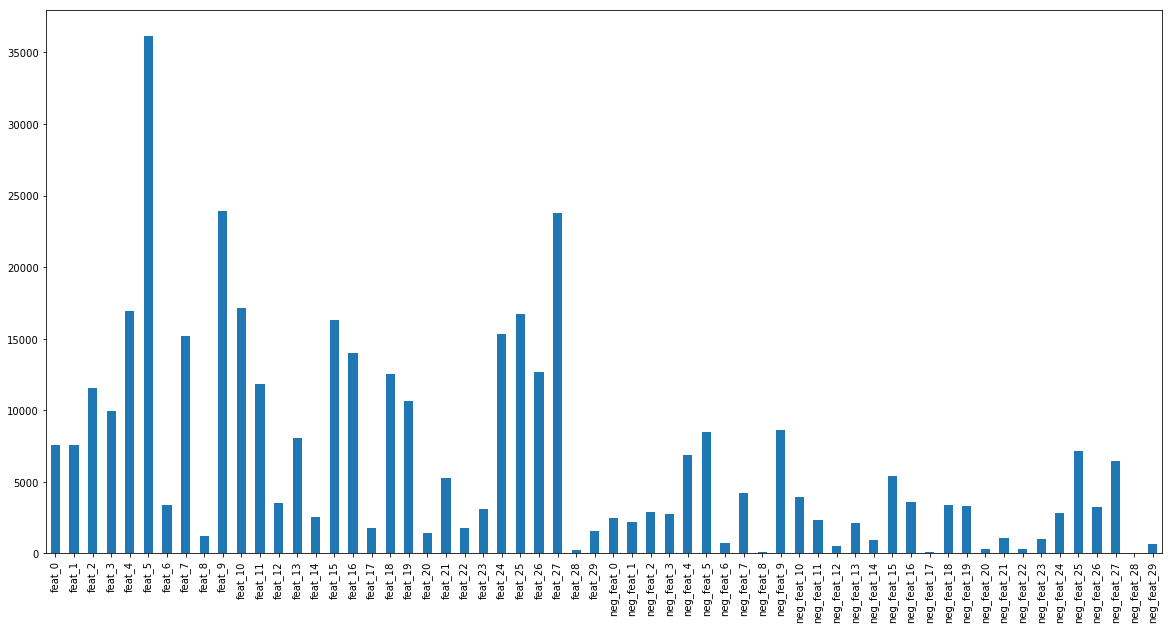

In [35]:
df_sentence_products_clusters = df_sentence_product_pos_neg[all_feature_columns + ['product_id']].groupby(['product_id']).sum()

# How many results for each feature type?
df_sentence_products_clusters.sum(axis=0).plot(kind='bar', figsize=(20,10))

In [36]:
df_sentence_products_clusters.head() # Unnormalized, Uncentered

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,neg_feat_20,neg_feat_21,neg_feat_22,neg_feat_23,neg_feat_24,neg_feat_25,neg_feat_26,neg_feat_27,neg_feat_28,neg_feat_29
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,8.0,7.0,12.0,14.0,11.0,32.0,1.0,12.0,4.0,10.0,...,0.0,0.0,0.0,1.0,3.0,6.0,5.0,4.0,0.0,1.0
P102504,17.0,7.0,13.0,16.0,29.0,49.0,1.0,28.0,3.0,39.0,...,0.0,2.0,0.0,2.0,7.0,11.0,3.0,8.0,0.0,0.0
P107306,12.0,9.0,3.0,0.0,21.0,33.0,3.0,19.0,2.0,32.0,...,1.0,3.0,0.0,3.0,6.0,6.0,2.0,6.0,0.0,2.0
P112400,1.0,3.0,3.0,18.0,4.0,10.0,1.0,2.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P113608,12.0,26.0,19.0,8.0,23.0,68.0,0.0,25.0,0.0,38.0,...,0.0,0.0,0.0,5.0,0.0,3.0,8.0,9.0,0.0,0.0


In [37]:
products_cluster_normalized = normalize(df_sentence_products_clusters) # Normalized and not Centered
df_products_cluster_normalized = pd.DataFrame(data=products_cluster_normalized, columns=all_feature_columns, index=df_sentence_products_clusters.index)
df_products_cluster_normalized.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,neg_feat_20,neg_feat_21,neg_feat_22,neg_feat_23,neg_feat_24,neg_feat_25,neg_feat_26,neg_feat_27,neg_feat_28,neg_feat_29
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,0.142359,0.124564,0.213538,0.249128,0.195743,0.569435,0.017795,0.213538,0.071179,0.177948,...,0.000000,0.000000,0.0,0.017795,0.053385,0.106769,0.088974,0.071179,0.0,0.017795
P102504,0.141368,0.058210,0.108105,0.133052,0.241156,0.407471,0.008316,0.232841,0.024947,0.324314,...,0.000000,0.016631,0.0,0.016631,0.058210,0.091473,0.024947,0.066526,0.0,0.000000
P107306,0.125587,0.094191,0.031397,0.000000,0.219778,0.345365,0.031397,0.198847,0.020931,0.334900,...,0.010466,0.031397,0.0,0.031397,0.062794,0.062794,0.020931,0.062794,0.0,0.020931
P112400,0.034586,0.103757,0.103757,0.622543,0.138343,0.345857,0.034586,0.069171,0.069171,0.172929,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
P113608,0.081956,0.177571,0.129763,0.054637,0.157082,0.464415,0.000000,0.170741,0.000000,0.259526,...,0.000000,0.000000,0.0,0.034148,0.000000,0.020489,0.054637,0.061467,0.0,0.000000


In [38]:
# Run one time
df_products_cluster_normalized.to_csv('data/product_features.csv')

In [39]:
# Sanity check
df_products_cluster_normalized.loc['P102503'].nlargest(5)

feat_5     0.569435
feat_10    0.284717
feat_3     0.249128
feat_2     0.213538
feat_7     0.213538
Name: P102503, dtype: float64

In [40]:
top_feature_columns = ['5th', '4th', '3rd', '2nd', '1st']
df_top_features_products = pd.DataFrame(data=products_cluster_normalized.argsort(axis = 1)[:, -5:], 
                                columns=top_feature_columns, index=df_products_cluster_normalized.index)
df_top_features_products = df_top_features_products.applymap(lambda index: all_feature_columns[index])
df_top_features_products.head()

,5th,4th,3rd,2nd,1st
product_id,,,,,
P102503,feat_25,feat_7,feat_3,feat_10,feat_5
P102504,feat_4,feat_18,feat_27,feat_9,feat_5
P107306,feat_18,feat_16,feat_9,feat_10,feat_5
P112400,feat_11,feat_10,feat_27,feat_5,feat_3
P113608,feat_10,feat_9,feat_11,feat_27,feat_5


In [41]:
dict_sentence_product_pos_neg = df_sentence_product_pos_neg.to_dict()

In [42]:
sentence_columns = ['5th_sent', '4th_sent', '3rd_sent', '2nd_sent', '1st_sent']
def get_product_sentence(row):
    product_id = row.name
    for top_feat_col in top_feature_columns:
        # print(product_id, top_feat_col, row[top_feat_col])
        feat_col = row[top_feat_col]       
        sample_sentence = ''
        indexes_for_prod = [k for k, v in dict_sentence_product_pos_neg['product_id'].items() if v == product_id]
        indexes_for_feat = [k for k in indexes_for_prod if dict_sentence_product_pos_neg[feat_col][k] > 0]
        sentences_for_feat = [dict_sentence_product_pos_neg['sentence'][k] for k in indexes_for_feat]
        if (len(sentences_for_feat) > 0):
            sample_sentence = sentences_for_feat[0]
        row[top_feat_col + '_sent'] = sample_sentence
    return row

# Sample sentences for top features for each product
df_top_features_products = df_top_features_products.apply(lambda row: get_product_sentence(row), axis=1)

KeyboardInterrupt: 

In [ ]:
df_top_features_products.head()

## PCA on Product Sentence Features

In [ ]:
# df_products_cluster_centered = df_sentence_products_clusters - df_sentence_products_clusters.mean()
# df_products_cluster_centered.head()

In [ ]:
""" 
pca = PCA(n_components=20)

# Transform X_centered to X_pca via a fit_transform
products_cluster_counts_pca = pca.fit_transform(products_cluster_normalized)
plt.bar(range(1, 21), pca.explained_variance_ratio_)
"""

## Clustering Products

In [ ]:
plot_kmeans_inertia(products_cluster_normalized)

In [ ]:
product_cluster_count = 7
km = KMeans(n_clusters=product_cluster_count)
product_clusters = km.fit_predict(products_cluster_normalized)
product_ids = df_sentence_products_clusters.index

cluster_to_product_ids = {}
for product_cluster_index in range(0, product_cluster_count):
    df_product_indexes = product_ids[product_clusters == product_cluster_index]
    product_names = df_product.loc[df_product_indexes]['product_url']
    cluster_to_product_ids[product_cluster_index] = product_names
# P116609', 'P116610'    
cluster_to_product_ids

## T-SNE

In [ ]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=70).fit_transform(products_cluster_normalized)


In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_clusters)

In [ ]:
df_top_features_products.head()

In [ ]:
# Top 5 sentences for 
# Write to CSV
df_product_filtered = df_product.loc[df_sentence_products_clusters.index]
df_product_filtered['cluster'] = product_clusters
df_product_filtered['tsne_0'] = X_embedded[:, 0]
df_product_filtered['tsne_1'] = X_embedded[:, 1]
df_product_filtered = pd.concat([df_product_filtered, df_top_features_products], axis=1)
df_product_filtered.head()

In [ ]:
df_product_filtered.to_csv('data/tsne_product.csv')

In [ ]:
max(X_embedded[:, 0])

In [ ]:
x = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
normalize(x)